# Exploratory Data Analysis
This notebook creates features from raw tables and visualizes the results.

## 1. Set environment
Import libraries

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install isodate
    !pip install vaderSentiment
    !pip install stargazer
    !git clone https://github.com/ArturoSbr/youtube-dislike-count
    %cd youtube-dislike-count/cod/02_analysis

In [2]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
from isodate import parse_duration
from scipy.stats import ttest_ind
from stargazer.stargazer import Stargazer

Read datasets

In [3]:
d1 = pd.read_csv('../../dat/videoDetails.csv')
d2 = pd.read_csv('../../dat/videoFlags.csv')
df = pd.merge(d1, d2, on='videoId', how='right')

Data summary

In [4]:
nvids = d2['videoId'].nunique()
ncoms = round(df['post12CommentsNum'].sum(), -5)

print(f'Scraped {int(ncoms)} from {nvids} Political videos.')

Scraped 500000 from 1533 Political videos.


## 2. Feature creation
Add constant term

In [5]:
df['const'] = 1

Convert `publishedAt` to datetime format

In [6]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

Turn `definition` to dummy

In [7]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create targets from counters

In [8]:
# Hours (12, 24, 36, ...)
hours = list(np.arange(12, 72+1, 12))

# NCR and sNCR
for h in hours:
    df[f'ncr1Post{h}'] = df[f'post{h}CommentsNeg1'] / df[f'post{h}CommentsNum'].replace(0, 0.1)
    df[f'ncr2Post{h}'] = df[f'post{h}CommentsNeg2'] / df[f'post{h}CommentsNum'].replace(0, 0.1)

Analyze most important words in video titles to create dummy variables

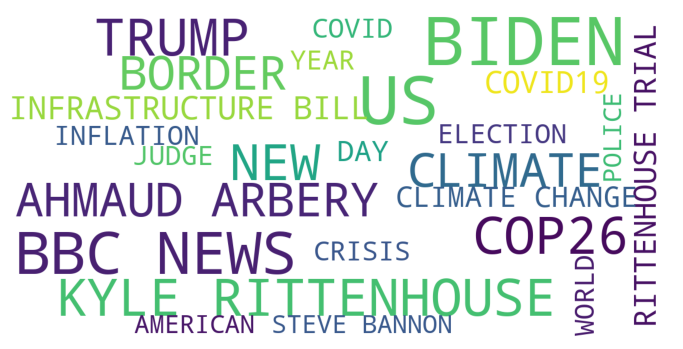

In [9]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()
# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS','S'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

# Show wordcloud
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Create dummy variables by topic

In [10]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
topics = {
    'president':'biden|trump',
    'climate':'cop26|cop 26|climate',
    'economy':'inflation|infrastructure|bill|economy',
    'covid':'covid|covid19|covid-19|virus',
    'violence':'kill|murder|assassins| die|dead|shoot|shot'
}

# Create Indicator variables
for topic in topics.keys():
    df[topic] = np.where(df['title'].str.contains(topics[topic]), 1, 0)

Video title sentiment

In [11]:
clf = SentimentIntensityAnalyzer()
df['toneCom'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])
df['tonePos'] = df['title'].apply(lambda x: clf.polarity_scores(x)['pos'])
df['toneNeg'] = df['title'].apply(lambda x: clf.polarity_scores(x)['neg'])

Translate `duration` to seconds.

In [12]:
# YT-duration format to seconds
df['seconds'] = df['duration'].apply(lambda x: int(parse_duration(x).total_seconds()))

# log(seconds)
df['logSeconds'] = np.log(df['seconds'])

Sort data by upload date

In [13]:
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

Treatment indicator

In [14]:
df['treat'] = (df['publishedAt'] > '2021-11-10').astype(int)

Declare running variable $R_i$ and interaction term $R_i \times T_i$
- Before: Seconds until treatment (control was positive, treatment was negative)
- Update: Seconds since treatment (control is negative, treatment is positive)

In [15]:
# Running variable
df['r'] = (df['publishedAt'] - pd.Timestamp('2021-11-10')).dt.total_seconds()

# Interaction
df['rTreat'] = df['r'].multiply(df['treat'])

## 3. Balance tests
List of targets

In [16]:
windows = [f'Post{h}' for h in hours]

### 3.1. Descriptive statistics
Number of available videos as a function of $h$

In [17]:
# post{h}CommentsNum
cols = [f'post{str(h)}CommentsNum' for h in hours]

# Merge to get videoId & post{h}CommentsNum
t = pd.merge(d1[['videoId','publishedAt']], d2[['videoId'] + cols], on='videoId', how='left')

# Create C&T groups
t['treat'] = (t['publishedAt'] > '2021-11-10').astype(int)

# Count available videos per window
t[cols] = t[cols].notna().astype(int)

# Group by
t = t.groupby('treat').agg({**{'videoId':'size'}, **dict(zip(cols,['sum']*6))}).transpose()

# Format
t.index = ['Total videos'] + ['h = ' + str(i*12) for i in range(1,7)]
t

# To latex
# print(t.to_latex(caption='Number of available videos for different values of $h$',
#                  label='tab_dat_nobs'))

treat,0,1
Total videos,831,899
h = 12,678,855
h = 24,583,855
h = 36,463,855
h = 48,428,855
h = 60,344,855
h = 72,319,855


### 3.2. Balance

Balance table for videos closest to the cutoff: $R_{hours} \in [-36,-12] \cup [24,36]$

1. Difference in means for binary covariates
1. RDD for continuous covariates

$$X_i = \gamma_0 + \gamma_1 r_i + \gamma_2 T_i + \gamma_3 r_i T_i + V_i$$

In [18]:
# Bandwidth
mask = df['r'].between(-36*60*60, -12*60*60) | df['r'].between(24*60*60, 48*60*60)
print(f'{mask.sum()} videos used in balance test.')
d = df[mask].copy()

d['durationMins'] = d['seconds'].div(60)

# Order frequent-word variables by frequency
X = list(topics.keys()) + ['definition','durationMins','tonePos','toneNeg','toneCom']

# Regress each variable on r and treat
data = []
for x in X:
    m = sm.OLS(endog=d[x], exog=d[['const','r','treat','rTreat']]).fit()
    data.append((m.params['treat'], m.pvalues['treat']))

# Summary table
t = pd.DataFrame(data=data, index=X, columns=['Estimated Value','p-value'])
t.index.rename('Covariate', inplace=True)
t.reset_index(inplace=True)
t.round(3)

# To latex
# print(t.to_latex(caption='Regression discontinuities on observable characteristics',
#                  label='tab_dat_balance', float_format='%.3f', index=False))

435 videos used in balance test.


,Covariate,Estimated Value,p-value
0,president,0.358,0.013
1,climate,0.069,0.505
2,economy,0.130,0.216
3,covid,-0.012,0.861
4,violence,-0.151,0.206
5,definition,0.231,0.133
6,durationMins,-8.323,0.620
7,tonePos,0.001,0.991
8,toneNeg,0.034,0.650
9,toneCom,-0.018,0.915


## 4. Regression Analysis
Fit all polynomial models with $d \in \{1, 2\}$.

### 4.1. First-degree
$Y_i = \beta_0 + \beta_1 r_i + \beta_2 T_i + \beta_3 T_i \times r_i + \gamma X_i + U_i$

In [19]:
# Minumum number of comments
mask = df['post12CommentsNum'] > 0

# Fit all models
d1 = []
for target in ['ncr1','ncr2']:
    for window in windows:
        formula = f'{target}{window} ~ treat + r + I(r * treat)'
        m = sm.OLS.from_formula(formula=formula, data=df[mask]).fit(cov_type='HC0')
        d1.append(m)

$NCR(h)$ summary

In [20]:
# Summaries
ncr1d1 = Stargazer(d1[:6])
ncr1d1.dependent_variable_name('Dependent Variable: Negative Comment Ratio')
ncr1d1.custom_columns([f'h = {h}' for h in hours], [1]*6)
ncr1d1.covariate_order(['treat','r','I(r * treat)','Intercept'])#,'toneNeg'])
ncr1d1.rename_covariates({'I(r * treat)':'RxT','r':'R','treat':'T'})#,'toneNeg':'Negative tone'})
ncr1d1.show_degrees_of_freedom(False)
ncr1d1.add_custom_notes(['Robust standard errors (HC0)'])
ncr1d1.show_model_numbers(False)
ncr1d1.title('Estimated effects on Negative Comment Ratio (first-degree polynomial)')
ncr1d1

# Latex output
# print(ncr1d1.render_latex())

$sNCR(h)$ summaries

In [21]:
# Model summaries
ncr2d2 = Stargazer(d1[6:])
ncr2d2.dependent_variable_name('Dependent Variable: Somewhat Negative Comment Ratio')
ncr2d2.custom_columns([f'h = {h}' for h in hours], [1]*6)
ncr2d2.covariate_order(['treat','r','I(r * treat)','Intercept'])#,'toneNeg'])
ncr2d2.rename_covariates({'I(r * treat)':'RxT','r':'R','treat':'T'})#,'toneNeg':'Negative tone'})
ncr2d2.show_degrees_of_freedom(False)
ncr2d2.add_custom_notes(['Robust standard errors (HC0)'])
ncr2d2.show_model_numbers(False)
ncr2d2.title('Estimated effects on Somewhat Negative Comment Ratio (first-degree polynomial)')
ncr2d2

# Latex output
# print(ncr2d2.render_latex())

### 4.2. Second-degree
$$Y_i = \beta_0 + \beta_1 T_i + \beta_2 R_i + \beta_3 R_i^2 + \beta_4 (T_i \times R_i) + \beta_5 (T_i \times R_i^2) + \gamma X_i + U_i$$

In [22]:
# Minumum number of comments
mask = df['post12CommentsNum'] > 0

# Fit all models
d2 = []
for target in ['ncr1','ncr2']:
    for window in windows:
        formula = f'{target}{window} ~ treat + r + I(r**2) + I(treat * r) + I(treat * (r**2))'
        m = sm.OLS.from_formula(formula=formula, data=df[mask]).fit(cov_type='HC0')
        d2.append(m)

$NCR(h)$ summary

In [23]:
# Summaries
ncr1d2 = Stargazer(d2[:6])
ncr1d2.dependent_variable_name('Dependent Variable: Negative Comment Ratio')
ncr1d2.custom_columns([f'h = {h}' for h in hours], [1]*6)
ncr1d2.covariate_order(['treat','r','I(r ** 2)','I(treat * r)','I(treat * (r ** 2))','Intercept'])
ncr1d2.rename_covariates({
    'I(r ** 2)':'R^2', 'I(treat * (r ** 2))':'T x R^2', 'I(treat * r)':'T x R',
    'r':'R','treat':'T'})
ncr1d2.show_degrees_of_freedom(False)
ncr1d2.add_custom_notes(['Robust standard errors (HC0)'])
ncr1d2.show_model_numbers(False)
ncr1d2.title('Estimated effects on Negative Comment Ratio (second-degree polynomial)')
ncr1d2

# Latex output
# print(ncr1d2.render_latex())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '


$sNCR(h)$ summaries

In [24]:
# Summaries
ncr1d2 = Stargazer(d2[:6])
ncr1d2.dependent_variable_name('Dependent Variable: Somewhat Negative Comment Ratio')
ncr1d2.custom_columns([f'h = {h}' for h in hours], [1]*6)
ncr1d2.covariate_order(['treat','r','I(r ** 2)','I(treat * r)','I(treat * (r ** 2))','Intercept'])
ncr1d2.rename_covariates({
    'I(r ** 2)':'R^2', 'I(treat * (r ** 2))':'T x R^2', 'I(treat * r)':'T x R',
    'r':'R','treat':'T'})
ncr1d2.show_degrees_of_freedom(False)
ncr1d2.add_custom_notes(['Robust standard errors (HC0)'])
ncr1d2.show_model_numbers(False)
ncr1d2.title('Estimated effects on Somewhat Negative Comment Ratio (second-degree polynomial)')
ncr1d2

# Latex output
# print(ncr1d2.render_latex())

### 4.3. Robustness checks
#### 4.3.1. Control for president

### 4.4. Visualizations
Linear and quadratic RDD for $NCR(12)$

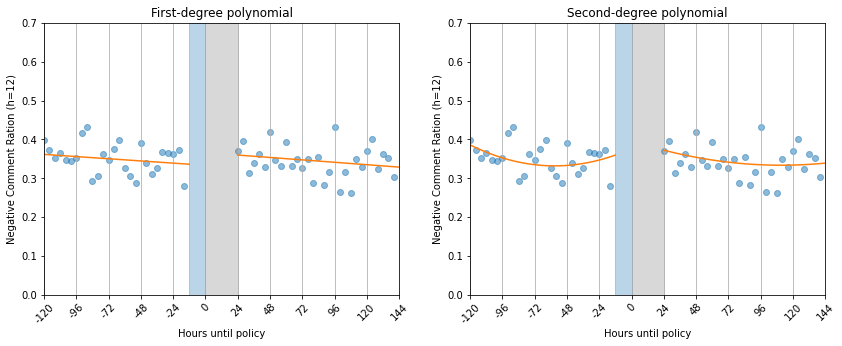

In [25]:
# Linrear and quadratic models
l, q = d1[0], d2[0]

# Data and predictions for lines
t = pd.DataFrame({'r':df.loc[mask, 'r'],
                  'l':d1[0].fittedvalues.values,
                  'q':d2[0].fittedvalues.values})
t['treat'] = (t['r'] > 0).astype(int)

# Data for scatter
bin_length = 4
s = df.loc[mask, ['ncr1Post12','r']].copy()
s['bin'] = (s['r'].div(60 * 60) / bin_length).apply(lambda x: floor(x))
s = s.groupby('bin')['ncr1Post12'].mean().reset_index(name='mean')
s['bin'] = s['bin'].multiply(bin_length * 60 * 60)

# Initialize figure
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(14)

# Plot model on each axis
for i, ax in enumerate(axs):
    # Plot linear model
    if i == 0:
        series = 'l'
    else:
        series = 'q'
    # Lines
    ax.plot(t.loc[t['treat'].eq(0), 'r'], t.loc[t['treat'].eq(0), series], color='C1')
    ax.plot(t.loc[t['treat'].eq(1), 'r'], t.loc[t['treat'].eq(1), series], color='C1')
    # Scatter
    ax.scatter(s['bin'], s['mean'], color='C0', alpha=0.5)
    # Shaded regions
    ax.axvspan(xmin=0, xmax=24*60*60, color='gray', alpha=0.3)
    ax.axvspan(xmin=-12*60*60, xmax=0, color='C0', alpha=0.3)
    # X&Y axes
    ax.set_xticks(np.arange(-5*24*60*60, 6*24*60*60+1, 24 * 60 * 60))
    ax.set_xticklabels(np.arange(-5*24, 6*24+1, 24), rotation=45)
    ax.set_xlim(-5*24*60*60, 6*24*60*60)
    ax.set_ylim(0, 0.7)
    # Labels
    title = {'l':'First-degree polynomial','q':'Second-degree polynomial'}
    ax.set_title(f'{title[series]}')
    ax.set_xlabel('Hours until policy')
    ax.set_ylabel('Negative Comment Ration (h=12)')
    ax.grid(which='major', axis='x')
# Save and show
if 'google.colab' not in sys.modules:
    plt.savefig('../../fig/fig_d1d2.png', dpi=200, bbox_inches='tight')
plt.show()

All linear models

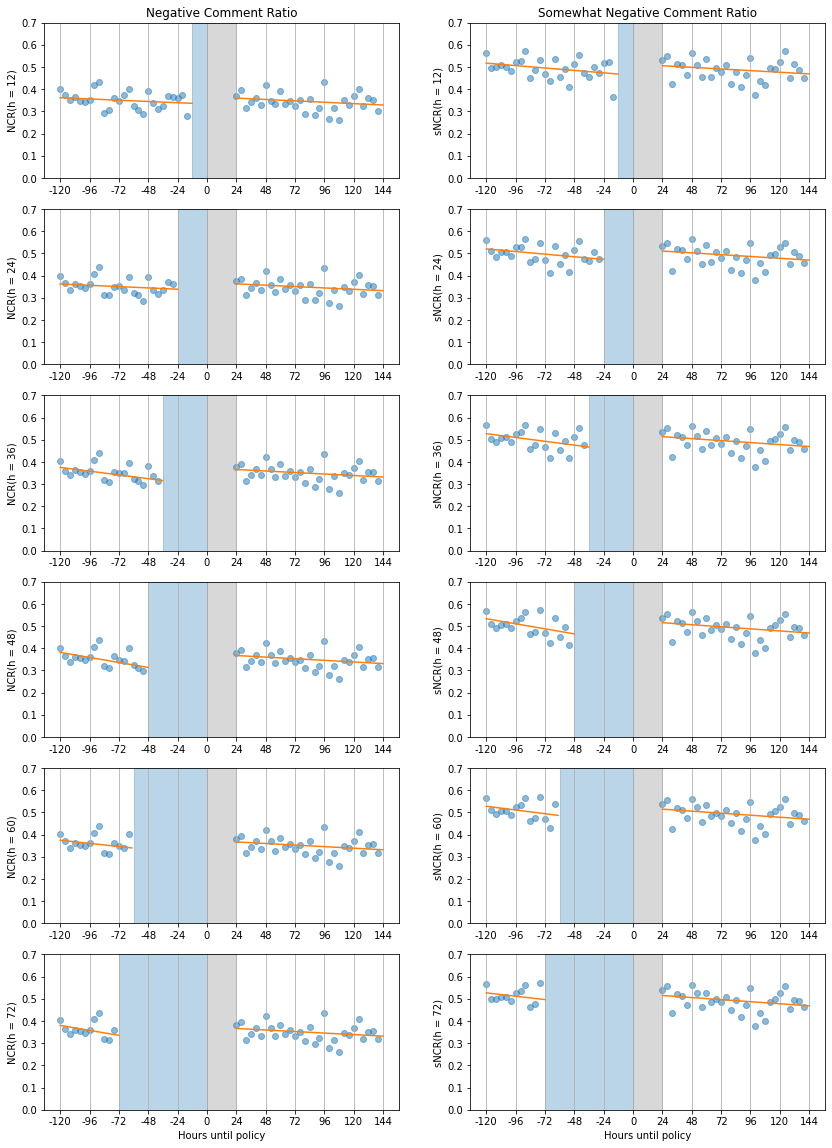

In [26]:
# Initialize figure
fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(14)

# Plot within each axis
for i, ax_row in enumerate(axs):
    # Left-right plots
    for j, ax in enumerate(ax_row):
        if j == 0:
            outcome = f'ncr1{windows[i]}'
            dotColor = 'blue'
            ax.set_ylabel(f'NCR(h = {hours[i]})')
            model = d1[i]
        else:
            outcome = f'ncr2{windows[i]}'
            dotColor = 'lightblue'
            ax.set_ylabel(f'sNCR(h = {hours[i]})')
            model = d1[6+i]
        # Masks
        mask = df['post12CommentsNum'].gt(0) & df[outcome].notna()
        # Line plots
        t = df.loc[mask, ['treat','r']].assign(pred = model.fittedvalues)
        ax.plot(t.loc[t['treat'].eq(0), 'r'], t.loc[t['treat'].eq(0), 'pred'], color='C1')
        ax.plot(t.loc[t['treat'].eq(1), 'r'], t.loc[t['treat'].eq(1), 'pred'], color='C1')
        # Scatter plots
        s = df[mask].copy()
        s['bin'] = (s['r'].div(4*60*60)).apply(lambda x: floor(x))
        s = s.groupby('bin')[outcome].mean().reset_index(name='mean')
        s['bin'] = s['bin'] * (4*60*60)
        ax.scatter(x=s['bin'], y=s['mean'], color='C0', alpha=0.5)
        # Shades
        ax.axvspan(xmin=0, xmax=24*60*60, color='gray', alpha=0.3)
        ax.axvspan(xmin=-hours[i]*60*60, xmax=0, color='C0', alpha=0.3)
        # Axes
        ax.set_ylim(0, 0.7)
        ax.set_xticks(np.arange(-5*24*60*60, 6*24*60*60+1, 24*60*60))
        ax.set_xticklabels(np.arange(-5*24, 6*24+1, 24))
        ax.grid(which='major', axis='x')
        if i == 0:
            ax.set_title({0:'Negative Comment Ratio',1:'Somewhat Negative Comment Ratio'}[j])
        if i == 5:
            ax.set_xlabel('Hours until policy')
# Show & save
if 'google.colab' not in sys.modules:
    plt.savefig('../../fig/fig_res_d1all.png', dpi=200, bbox_inches='tight')
plt.show()

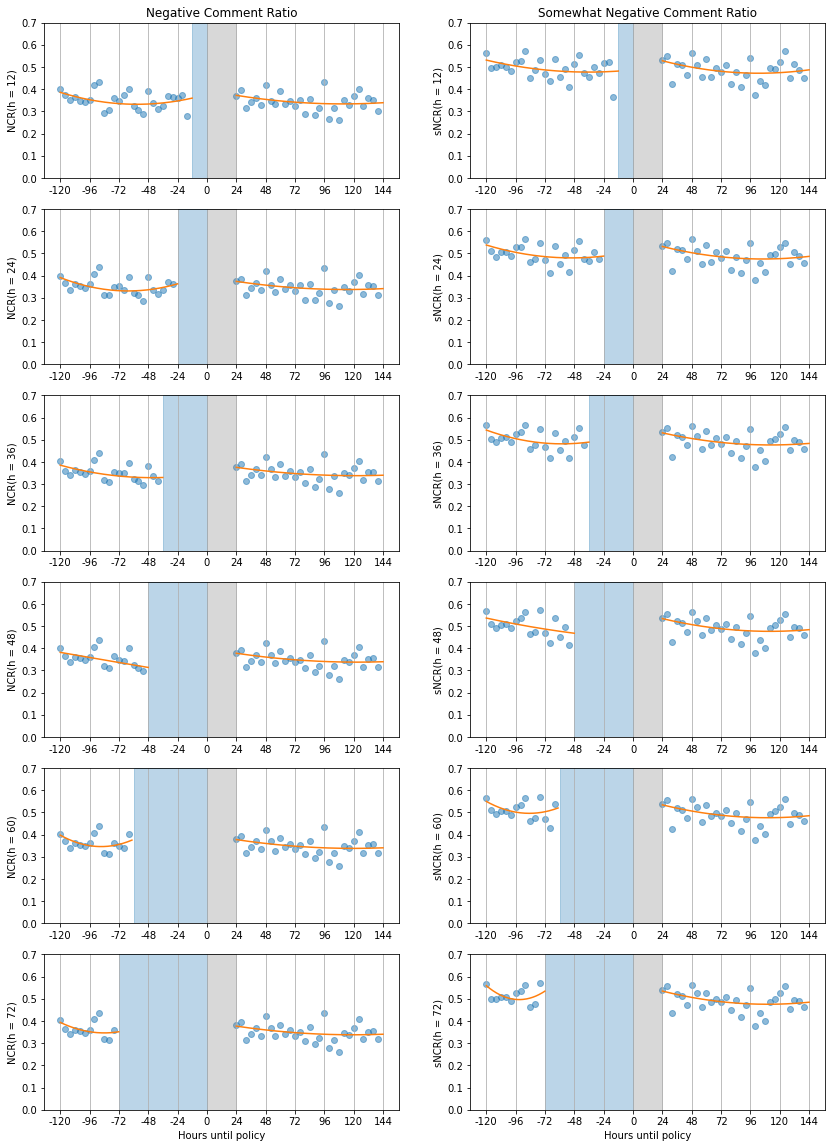

In [27]:
# Initialize figure
fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(14)

# Plot within each axis
for i, ax_row in enumerate(axs):
    # Left-right plots
    for j, ax in enumerate(ax_row):
        if j == 0:
            outcome = f'ncr1{windows[i]}'
            dotColor = 'blue'
            ax.set_ylabel(f'NCR(h = {hours[i]})')
            model = d2[i]
        else:
            outcome = f'ncr2{windows[i]}'
            dotColor = 'lightblue'
            ax.set_ylabel(f'sNCR(h = {hours[i]})')
            model = d2[6+i]
        # Masks
        mask = df['post12CommentsNum'].gt(0) & df[outcome].notna()
        # Line plots
        t = df.loc[mask, ['treat','r']].assign(pred = model.fittedvalues)
        ax.plot(t.loc[t['treat'].eq(0), 'r'], t.loc[t['treat'].eq(0), 'pred'], color='C1')
        ax.plot(t.loc[t['treat'].eq(1), 'r'], t.loc[t['treat'].eq(1), 'pred'], color='C1')
        # Scatter plots
        s = df[mask].copy()
        s['bin'] = (s['r'].div(4*60*60)).apply(lambda x: floor(x))
        s = s.groupby('bin')[outcome].mean().reset_index(name='mean')
        s['bin'] = s['bin'] * (4*60*60)
        ax.scatter(x=s['bin'], y=s['mean'], color='C0', alpha=0.5)
        # Shades
        ax.axvspan(xmin=0, xmax=24*60*60, color='gray', alpha=0.3)
        ax.axvspan(xmin=-hours[i]*60*60, xmax=0, color='C0', alpha=0.3)
        # Axes
        ax.set_ylim(0, 0.7)
        ax.set_xticks(np.arange(-5*24*60*60, 6*24*60*60+1, 24*60*60))
        ax.set_xticklabels(np.arange(-5*24, 6*24+1, 24))
        ax.grid(which='major', axis='x')
        if i == 0:
            ax.set_title({0:'Negative Comment Ratio',1:'Somewhat Negative Comment Ratio'}[j])
        if i == 5:
            ax.set_xlabel('Hours until policy')
# Show & save
if 'google.colab' not in sys.modules:
    plt.savefig('../../fig/fig_res_d2all.png', dpi=200, bbox_inches='tight')
plt.show()

Comparing linear to quadratic models

In [28]:
# Goodness of fit
t = pd.DataFrame(
    {
        'd1R2a':[m.rsquared_adj for m in d1], 'd2R2a':[m.rsquared_adj for m in d2],
        'd1bic':[m.bic for m in d1], 'd2bic':[m.bic for m in d2],
        'd1aic':[m.aic for m in d1], 'd2aic':[m.aic for m in d2],
    }
)

t.round(4)

,d1R2a,d2R2a,d1bic,d2bic,d1aic,d2aic
0,0.0012,0.0028,-1221.9478,-1211.7348,-1243.2432,-1243.6778
1,0.0010,0.0033,-1191.4080,-1182.1872,-1212.4501,-1213.7503
2,0.0046,0.0039,-1128.0078,-1114.7831,-1148.7005,-1145.8222
3,0.0066,0.0057,-1111.2057,-1097.6602,-1131.7959,-1128.5455
4,0.0029,0.0034,-1075.6437,-1064.0966,-1095.9671,-1094.5818
5,0.0035,0.0029,-1059.1935,-1046.4410,-1079.4320,-1076.7987
6,0.0038,0.0049,-921.0799,-910.0749,-942.3752,-942.0179
7,0.0044,0.0057,-948.4438,-937.7949,-969.4859,-969.3581
8,0.0059,0.0065,-893.1057,-881.4783,-913.7985,-912.5174
9,0.0077,0.0077,-881.1361,-868.8860,-901.7263,-899.7714
